In [1]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import ignite
from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [52]:
class Model_bilinear(nn.Module):
    def __init__(self, features, num_embeddings):
        super().__init__()
         
        self.gamma = 0.99
        self.sigma = 0.1
        
        embedding_size = 10
        self.fc1 = nn.Linear(1, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
#         print("N", self.N.shape, self.N)
#         print("m", self.m.shape, self.m)
        self.m = self.m * self.N.unsqueeze(0)
#         print("m", self.m.shape, self.m)

    def embed(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        
        # i is batch, m is embedding_size, n is num_embeddings (classes)
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x

    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)
#         print("m", self.m.shape, embeddings)
        diff = z - embeddings.unsqueeze(0)  
#         print("embeddings", embeddings)
        y_pred = (- diff**2).mean(1).div(2 * self.sigma**2).exp()

        return y_pred

    def forward(self, x):
        z = self.embed(x)
        y_pred = self.bilinear(z)
        
        return z, y_pred

    def update_embeddings(self, x, y):
        z = self.embed(x)
        
        # normalizing value per class, assumes y is one_hot encoded
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))
        
        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum('ijk,ik->jk', z, y)
        
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

In [53]:
# num_classes=2
# model = Model_bilinear(20, num_classes)
# print(model.W.shape)
# x, y = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
# print(type(x), y.shape)
# b = np.array([10])
# print(b.shape)
# a = model(torch.Tensor(b.reshape(-1, 1)))
# print(a[1])

In [54]:
def gaussianA(n_obs):
    return np.random.normal(0, 1, n_obs)

def gaussianB(n_obs):
    return np.random.normal(15, 1, n_obs)

In [55]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

In [56]:
def data_generator(batch_size, model_prior, forward_models, alpha_smooth=None, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)

    # For each model index, sample from prior and run generative model.
    x = []

    for m_idx in m_indices:
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](1)
#         print(x_m)
        # Store data and params
        x.append(x_m)
    
    return {'m': np.int64(m_indices), 'x': np.array(x)}

In [57]:
foward_models = [gaussianA, gaussianB]
model_prior = model_prior

D = data_generator(3000, model_prior, foward_models)
T = data_generator(300, model_prior, foward_models)


In [58]:
np.random.seed(0)
torch.manual_seed(0)

l_gradient_penalty = 1

# Moons
noise = 0.1
X_train, y_train = D['x'], D['m'] #sklearn.datasets.make_moons(n_samples=1500, noise=noise) #D['x'], D['m']
X_test, y_test = T['x'], T['m'] #sklearn.datasets.make_moons(n_samples=200, noise=noise) #T['x'], T['m'] 

num_classes = 2
batch_size = 128

model = Model_bilinear(25, num_classes)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)


def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]

#     print("x",x)
#     print("y", y_pred)
    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)
#     print("GRAD_NORM", grad_norm)
    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    
    # One sided penalty - down
#     gradient_penalty = F.relu(grad_norm - 1).mean()

    return gradient_penalty


def output_transform_acc(output):
    y_pred, y, x, z = output
    
    y = torch.argmax(y, dim=1)
        
    return y_pred, y


def output_transform_bce(output):
    y_pred, y, x, z = output

    return y_pred, y


def output_transform_gp(output):
    y_pred, y, x, z = output

    return x, y_pred


def step(engine, batch):
    model.train()
    optimizer.zero_grad()
    
    x, y = batch
    x.requires_grad_(True)
    
    z, y_pred = model(x)
    
    loss1 =  F.binary_cross_entropy(y_pred, y)
    loss2 = l_gradient_penalty * calc_gradient_penalty(x, y_pred)
    
    loss = loss1 + loss2
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.update_embeddings(x, y)
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()

    x, y = batch

    x.requires_grad_(True)

    z, y_pred = model(x)

    return y_pred, y, x, z
    

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Accuracy(output_transform=output_transform_acc)
metric.attach(evaluator, "accuracy")

metric = Loss(F.binary_cross_entropy, output_transform=output_transform_bce)
metric.attach(evaluator, "bce")

metric = Loss(calc_gradient_penalty, output_transform=output_transform_gp)
metric.attach(evaluator, "gp")


ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(dl_test)
    metrics = evaluator.state.metrics
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    x_lin = np.linspace(-10, 20, 1000).reshape(-1, 1)
    print(x_lin.shape)
    x_pdf = model(torch.Tensor(x_lin))[1].max(1)[0]
    ax.plot(x_lin, x_pdf.detach().numpy(), lw=2.5, alpha=0.8)
    print("Test Results - Epoch: {} Acc: {:.4f} BCE: {:.2f} GP {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['bce'], metrics['gp']))

(1000, 1)
Test Results - Epoch: 1 Acc: 0.5033 BCE: 22.22 GP 1.00
(1000, 1)
Test Results - Epoch: 2 Acc: 0.5033 BCE: 8.18 GP 0.72
(1000, 1)
Test Results - Epoch: 3 Acc: 0.9967 BCE: 0.26 GP 0.71
(1000, 1)
Test Results - Epoch: 4 Acc: 1.0000 BCE: 0.16 GP 0.67
(1000, 1)
Test Results - Epoch: 5 Acc: 1.0000 BCE: 0.14 GP 0.65
(1000, 1)
Test Results - Epoch: 6 Acc: 1.0000 BCE: 0.14 GP 0.63
(1000, 1)
Test Results - Epoch: 7 Acc: 1.0000 BCE: 0.16 GP 0.60
(1000, 1)
Test Results - Epoch: 8 Acc: 1.0000 BCE: 0.19 GP 0.56
(1000, 1)
Test Results - Epoch: 9 Acc: 1.0000 BCE: 0.18 GP 0.55
(1000, 1)
Test Results - Epoch: 10 Acc: 1.0000 BCE: 0.19 GP 0.53
(1000, 1)
Test Results - Epoch: 11 Acc: 1.0000 BCE: 0.15 GP 0.57
(1000, 1)
Test Results - Epoch: 12 Acc: 1.0000 BCE: 0.17 GP 0.53
(1000, 1)
Test Results - Epoch: 13 Acc: 1.0000 BCE: 0.17 GP 0.51
(1000, 1)
Test Results - Epoch: 14 Acc: 1.0000 BCE: 0.18 GP 0.48
(1000, 1)
Test Results - Epoch: 15 Acc: 1.0000 BCE: 0.22 GP 0.43
(1000, 1)
Test Results - Epoch: 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(1000, 1)
Test Results - Epoch: 21 Acc: 1.0000 BCE: 0.22 GP 0.43
(1000, 1)
Test Results - Epoch: 22 Acc: 1.0000 BCE: 0.23 GP 0.41
(1000, 1)
Test Results - Epoch: 23 Acc: 1.0000 BCE: 0.20 GP 0.43
(1000, 1)
Test Results - Epoch: 24 Acc: 1.0000 BCE: 0.22 GP 0.42
(1000, 1)
Test Results - Epoch: 25 Acc: 1.0000 BCE: 0.27 GP 0.40
(1000, 1)
Test Results - Epoch: 26 Acc: 1.0000 BCE: 0.21 GP 0.43
(1000, 1)
Test Results - Epoch: 27 Acc: 1.0000 BCE: 0.22 GP 0.43
(1000, 1)
Test Results - Epoch: 28 Acc: 1.0000 BCE: 0.23 GP 0.41
(1000, 1)
Test Results - Epoch: 29 Acc: 1.0000 BCE: 0.20 GP 0.44
(1000, 1)
Test Results - Epoch: 30 Acc: 1.0000 BCE: 0.22 GP 0.42


State:
	iteration: 690
	epoch: 30
	epoch_length: 23
	max_epochs: 30
	output: 0.6703874468803406
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

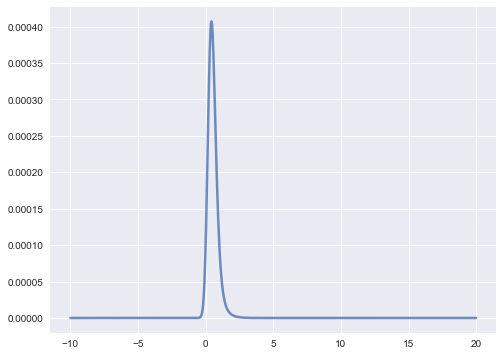

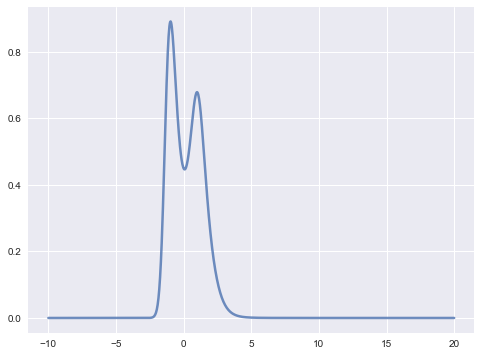

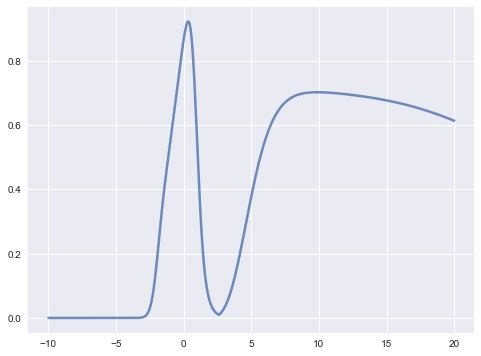

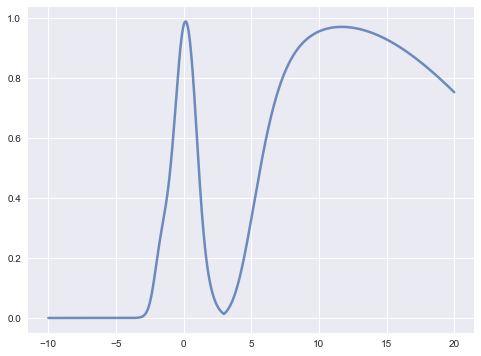

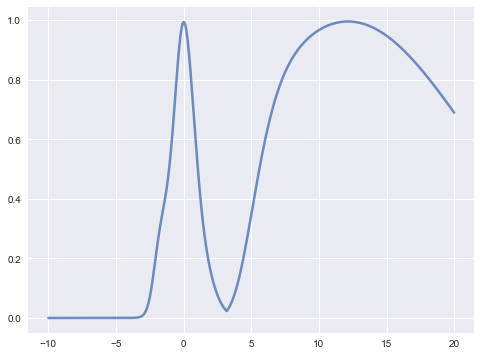

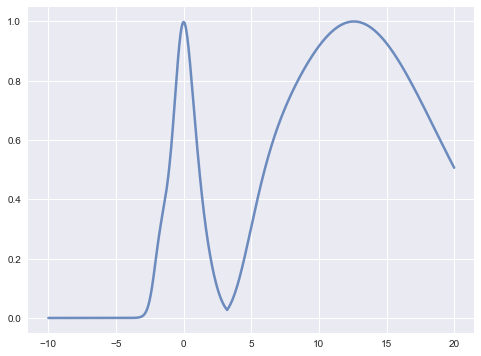

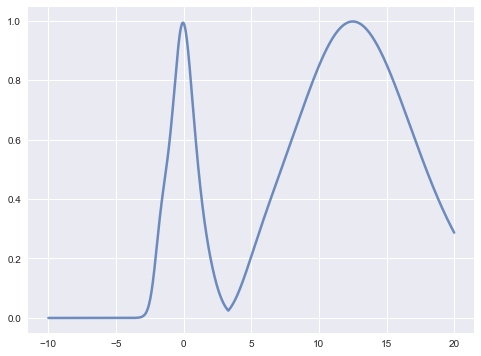

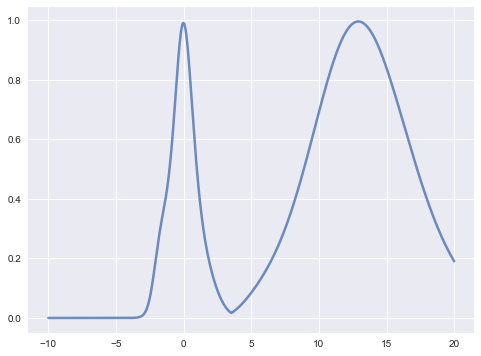

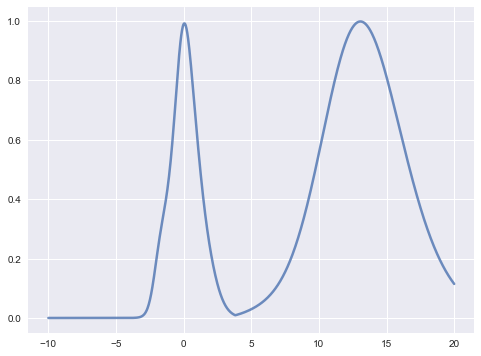

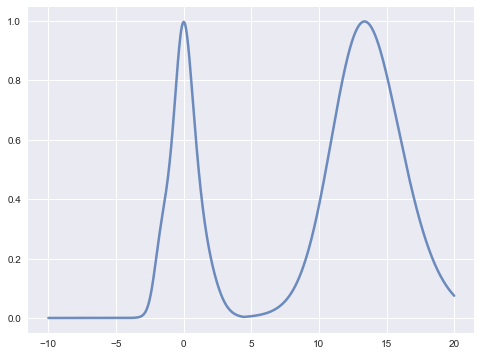

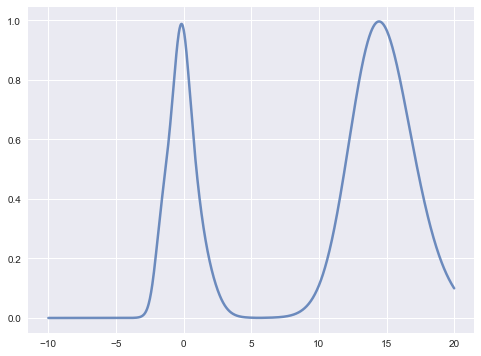

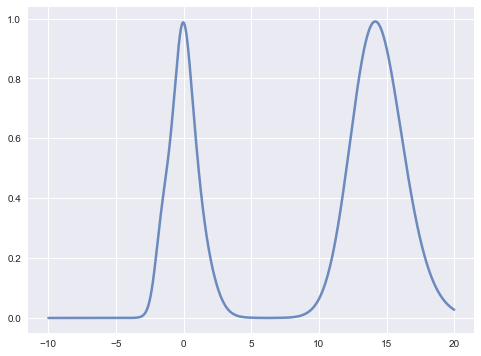

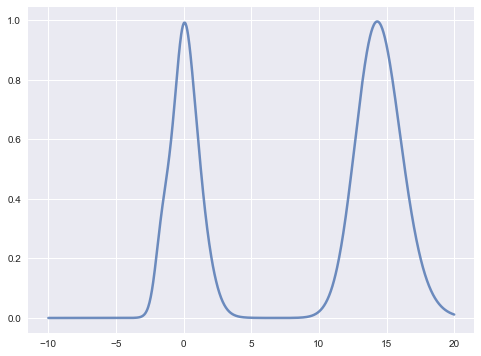

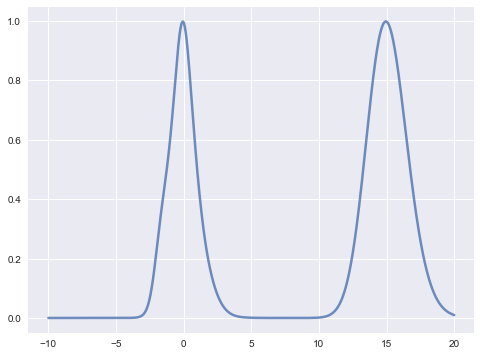

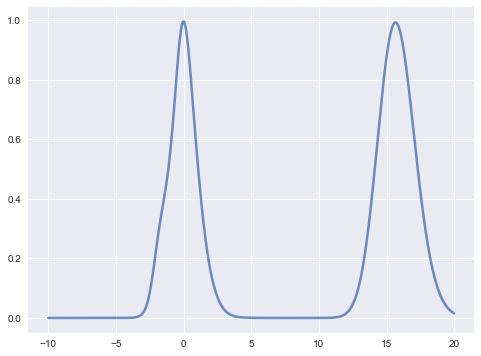

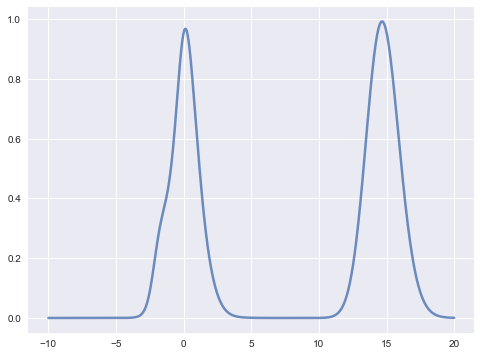

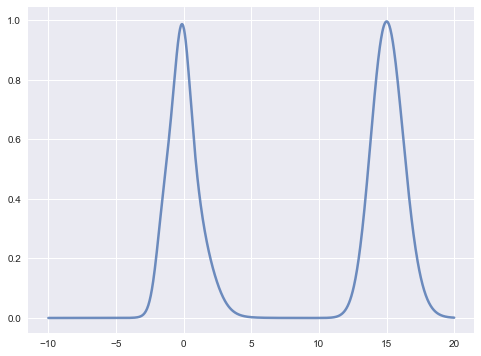

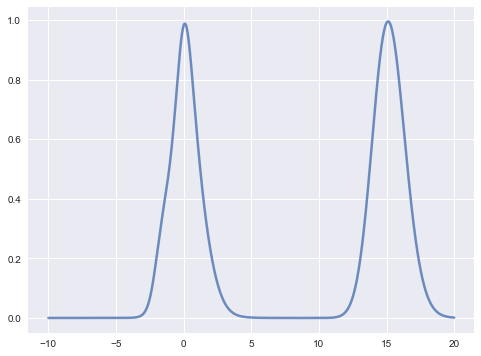

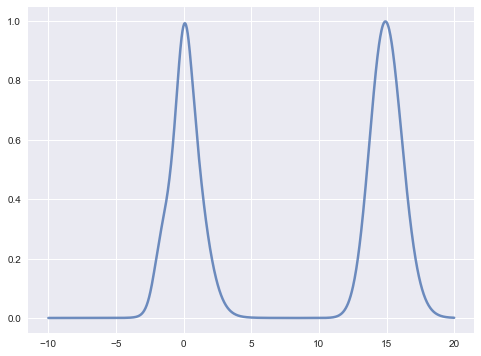

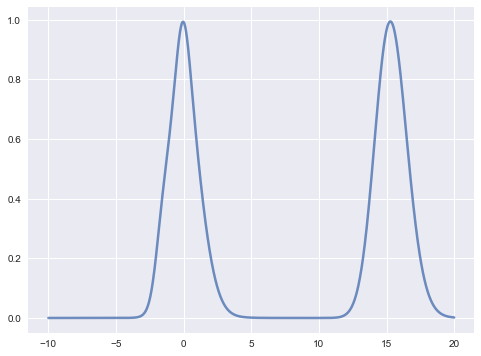

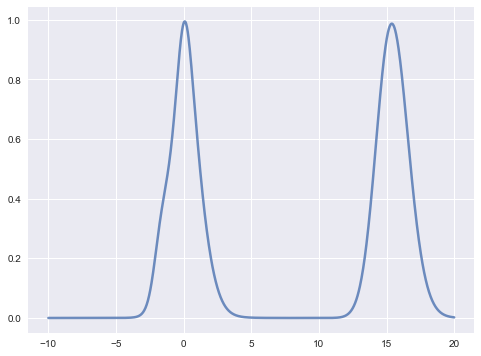

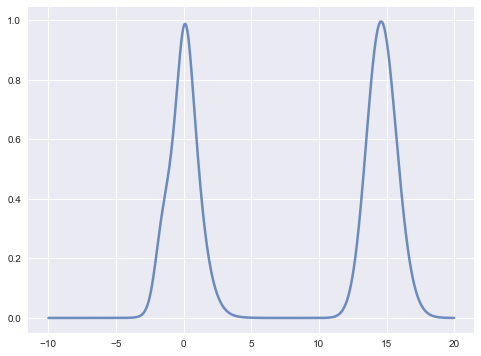

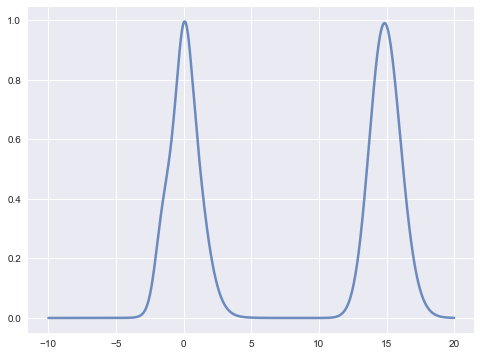

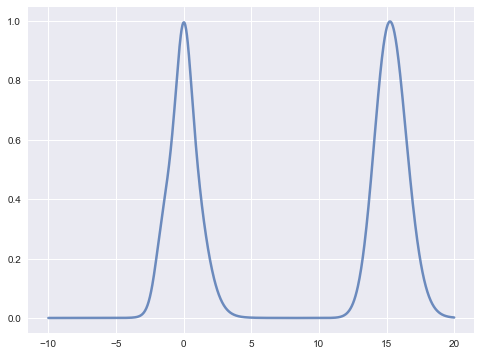

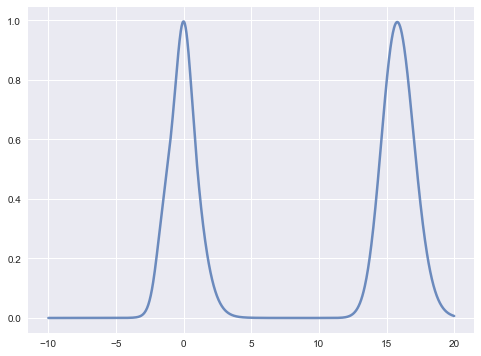

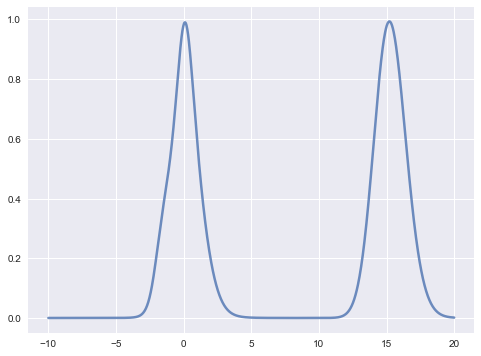

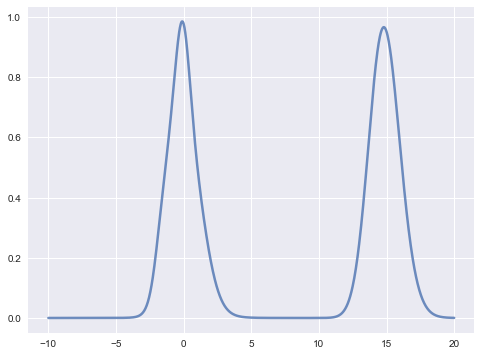

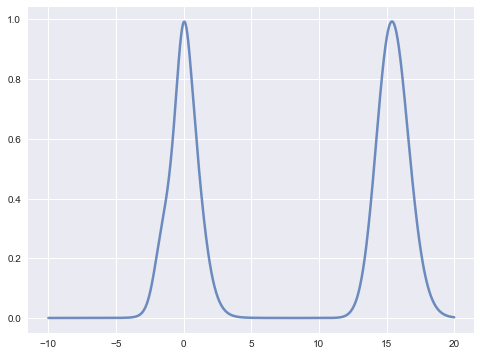

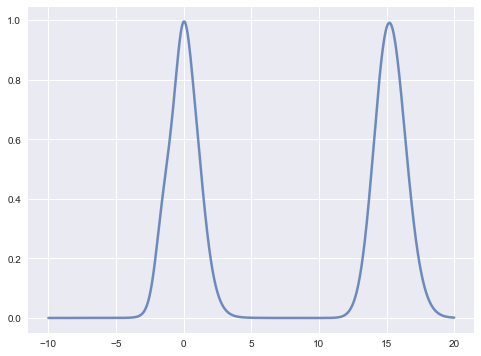

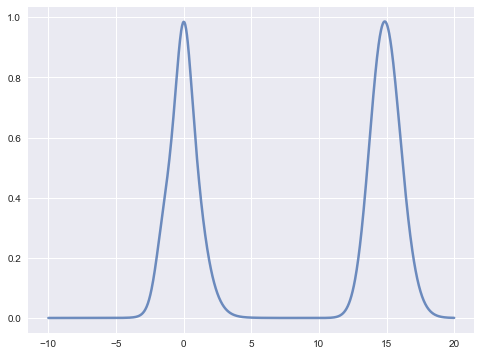

In [59]:
trainer.run(dl_train, max_epochs=30)

(1000, 1)
Parameter containing:
tensor([[[-0.2919,  0.9946, -0.5418, -1.6803, -0.5139, -0.4925, -0.6078,
          -1.4382,  0.6283],
         [-0.6226, -1.0173, -0.6360, -0.0624,  0.4068, -0.3484,  1.2160,
          -0.4085, -1.1954]],

        [[ 0.3645, -0.0245,  1.3881, -0.2943, -0.5038, -2.9041, -0.9976,
          -0.0551,  0.2318],
         [-0.6595,  1.6139,  0.2689,  1.0371,  1.3762, -0.1964, -1.2615,
          -0.7301,  1.6346]],

        [[-0.9462, -0.6225,  0.0800,  0.5459,  1.1476, -1.7642, -1.0954,
          -1.7063,  1.5336],
         [-0.0828, -1.5321,  0.1391,  0.5127, -0.1138,  1.1126, -0.2114,
           0.0176,  0.6992]],

        [[ 0.5637,  0.0996,  1.8348,  0.4844, -0.0458, -0.9174,  0.8484,
           1.0410,  2.0395],
         [-0.9423, -0.1074, -0.1440,  1.4450, -0.6664,  0.1568,  1.3146,
           2.0291,  0.6515]],

        [[ 1.7352,  1.9933,  0.1954, -0.5030,  0.8624,  0.5404, -0.7767,
           1.1981, -0.5913],
         [-0.9356, -0.8414, -0.5118,  0.08

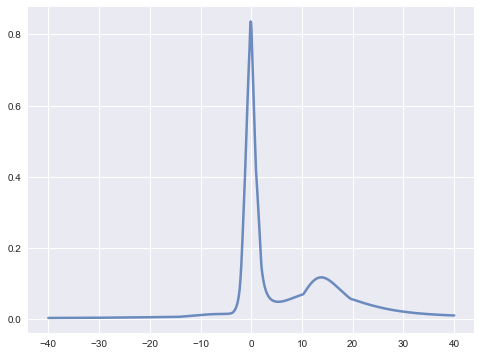

In [634]:
# x = data_generator(300, model_prior, foward_models)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
x_lin = np.linspace(-40, 40, 1000).reshape(-1, 1)
print(x_lin.shape)
x_pdf = model(torch.Tensor(x_lin))[1].max(1)[0]
ax.plot(x_lin, x_pdf.detach().numpy(), lw=2.5, alpha=0.8)
print(model.W)

# print(x.shape)
# with torch.no_grad():
#     a = model(torch.Tensor(x.reshape(-1, 1)))
#     print(a[1].max(1)[0])
#     b = model.embed(torch.Tensor(b.reshape(-1, 2)))
#     print(b[0, :, 1].mean())

In [511]:
x = np.array([15])
with torch.no_grad():
    a = model(torch.Tensor(x.reshape(-1, 1)))
    
    print(a[1])
#     b = model.embed(torch.Tensor(b.reshape(-1, 2)))
#     print(b[0, :, 1].mean())

tensor([[1.0204e-21, 9.8565e-01]])


In [60]:
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(np.bool)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())[1]
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])

RuntimeError: size mismatch, m1: [10000 x 2], m2: [1 x 25] at ../aten/src/TH/generic/THTensorMath.cpp:197